In [321]:
import pandas as pd

In [322]:
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", 
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", 
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", 
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", 
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "class","difficulty"
]


In [323]:
train = pd.read_csv('KDDTrain+.txt' , names = columns)
test = pd.read_csv('KDDTest+.txt' , names=columns)

In [324]:
train.drop(columns=['difficulty'] , inplace=True)
test.drop(columns=['difficulty'] , inplace=True)

In [325]:
attack_mapping = {
    'neptune': 'DOS', 'smurf': 'DOS', 'back': 'DOS', 'teardrop': 'DOS', 'pod': 'DOS', 'land': 'DOS',
    'apache2': 'DOS', 'processtable': 'DOS', 'udpstorm': 'DOS', 'mailbomb': 'DOS',
    
    'ipsweep': 'PROBE', 'portsweep': 'PROBE', 'nmap': 'PROBE', 'satan': 'PROBE', 'mscan': 'PROBE', 'saint': 'PROBE',
    
    'guess_passwd': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L', 'imap': 'R2L',
    'ftp_write': 'R2L', 'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L',
    'httptunnel': 'R2L', 'named': 'R2L', 'sendmail': 'R2L',
    
    'buffer_overflow': 'U2R', 'rootkit': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R',
    'ps': 'U2R', 'xterm': 'U2R', 'xlock': 'U2R', 'xsnoop': 'U2R', 'worm': 'U2R',
    'sqlattack': 'U2R'
}


In [326]:
train['class'] = train['class'].replace(attack_mapping)
test['class'] = test['class'].replace(attack_mapping)


In [327]:
train['class'].value_counts()

class
normal    67343
DOS       45927
PROBE     11656
R2L         995
U2R          52
Name: count, dtype: int64

In [328]:
for col in train.select_dtypes(include=['number']).columns :
    train[col] = train[col].fillna(train[col].median())

In [329]:
for col in test.select_dtypes(include=['number']).columns :
    test[col] = test[col].fillna(test[col].median())

In [330]:
print(train['duration'].min() , train['duration'].max())
print(test['duration'].min() , test['duration'].max())

0 42908
0 57715


In [331]:
bins = [-0.1 , 0 , 10000 , 20000 , 30000 , 40000 , 50000 , 60000]
labels = ['0' , '0-10000','10000-20000','20000-30000','30000-40000','40000 - 50000' , '50000 - 60000']

In [332]:
train['duration_bin'] = pd.cut(train['duration'] , bins=bins , labels=labels)
test['duration_bin'] = pd.cut(test['duration'] , bins=bins , labels=labels)

In [333]:
train.drop(columns=['duration'] , inplace=True)
test.drop(columns=['duration'] , inplace=True)

In [334]:
x = train.drop(columns=['class'])
y = train['class']

In [335]:
from sklearn.model_selection import train_test_split


In [336]:
x_train, x_test, y_train, y_test = train_test_split(
    x , y, test_size=0.2 , random_state=42)

In [337]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder

le = LabelEncoder()

# List of categorical columns
categorical_cols = ['protocol_type', 'service', 'flag' , 'duration_bin']

# Apply label encoding to both train and test datasets
for col in categorical_cols:
    le.fit(x_train[col])  # Fit only on training data
    x_train[col] = le.transform(x_train[col])  # Transform training data
    x_test[col] = le.transform(x_test[col]) 

In [338]:
le2 = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

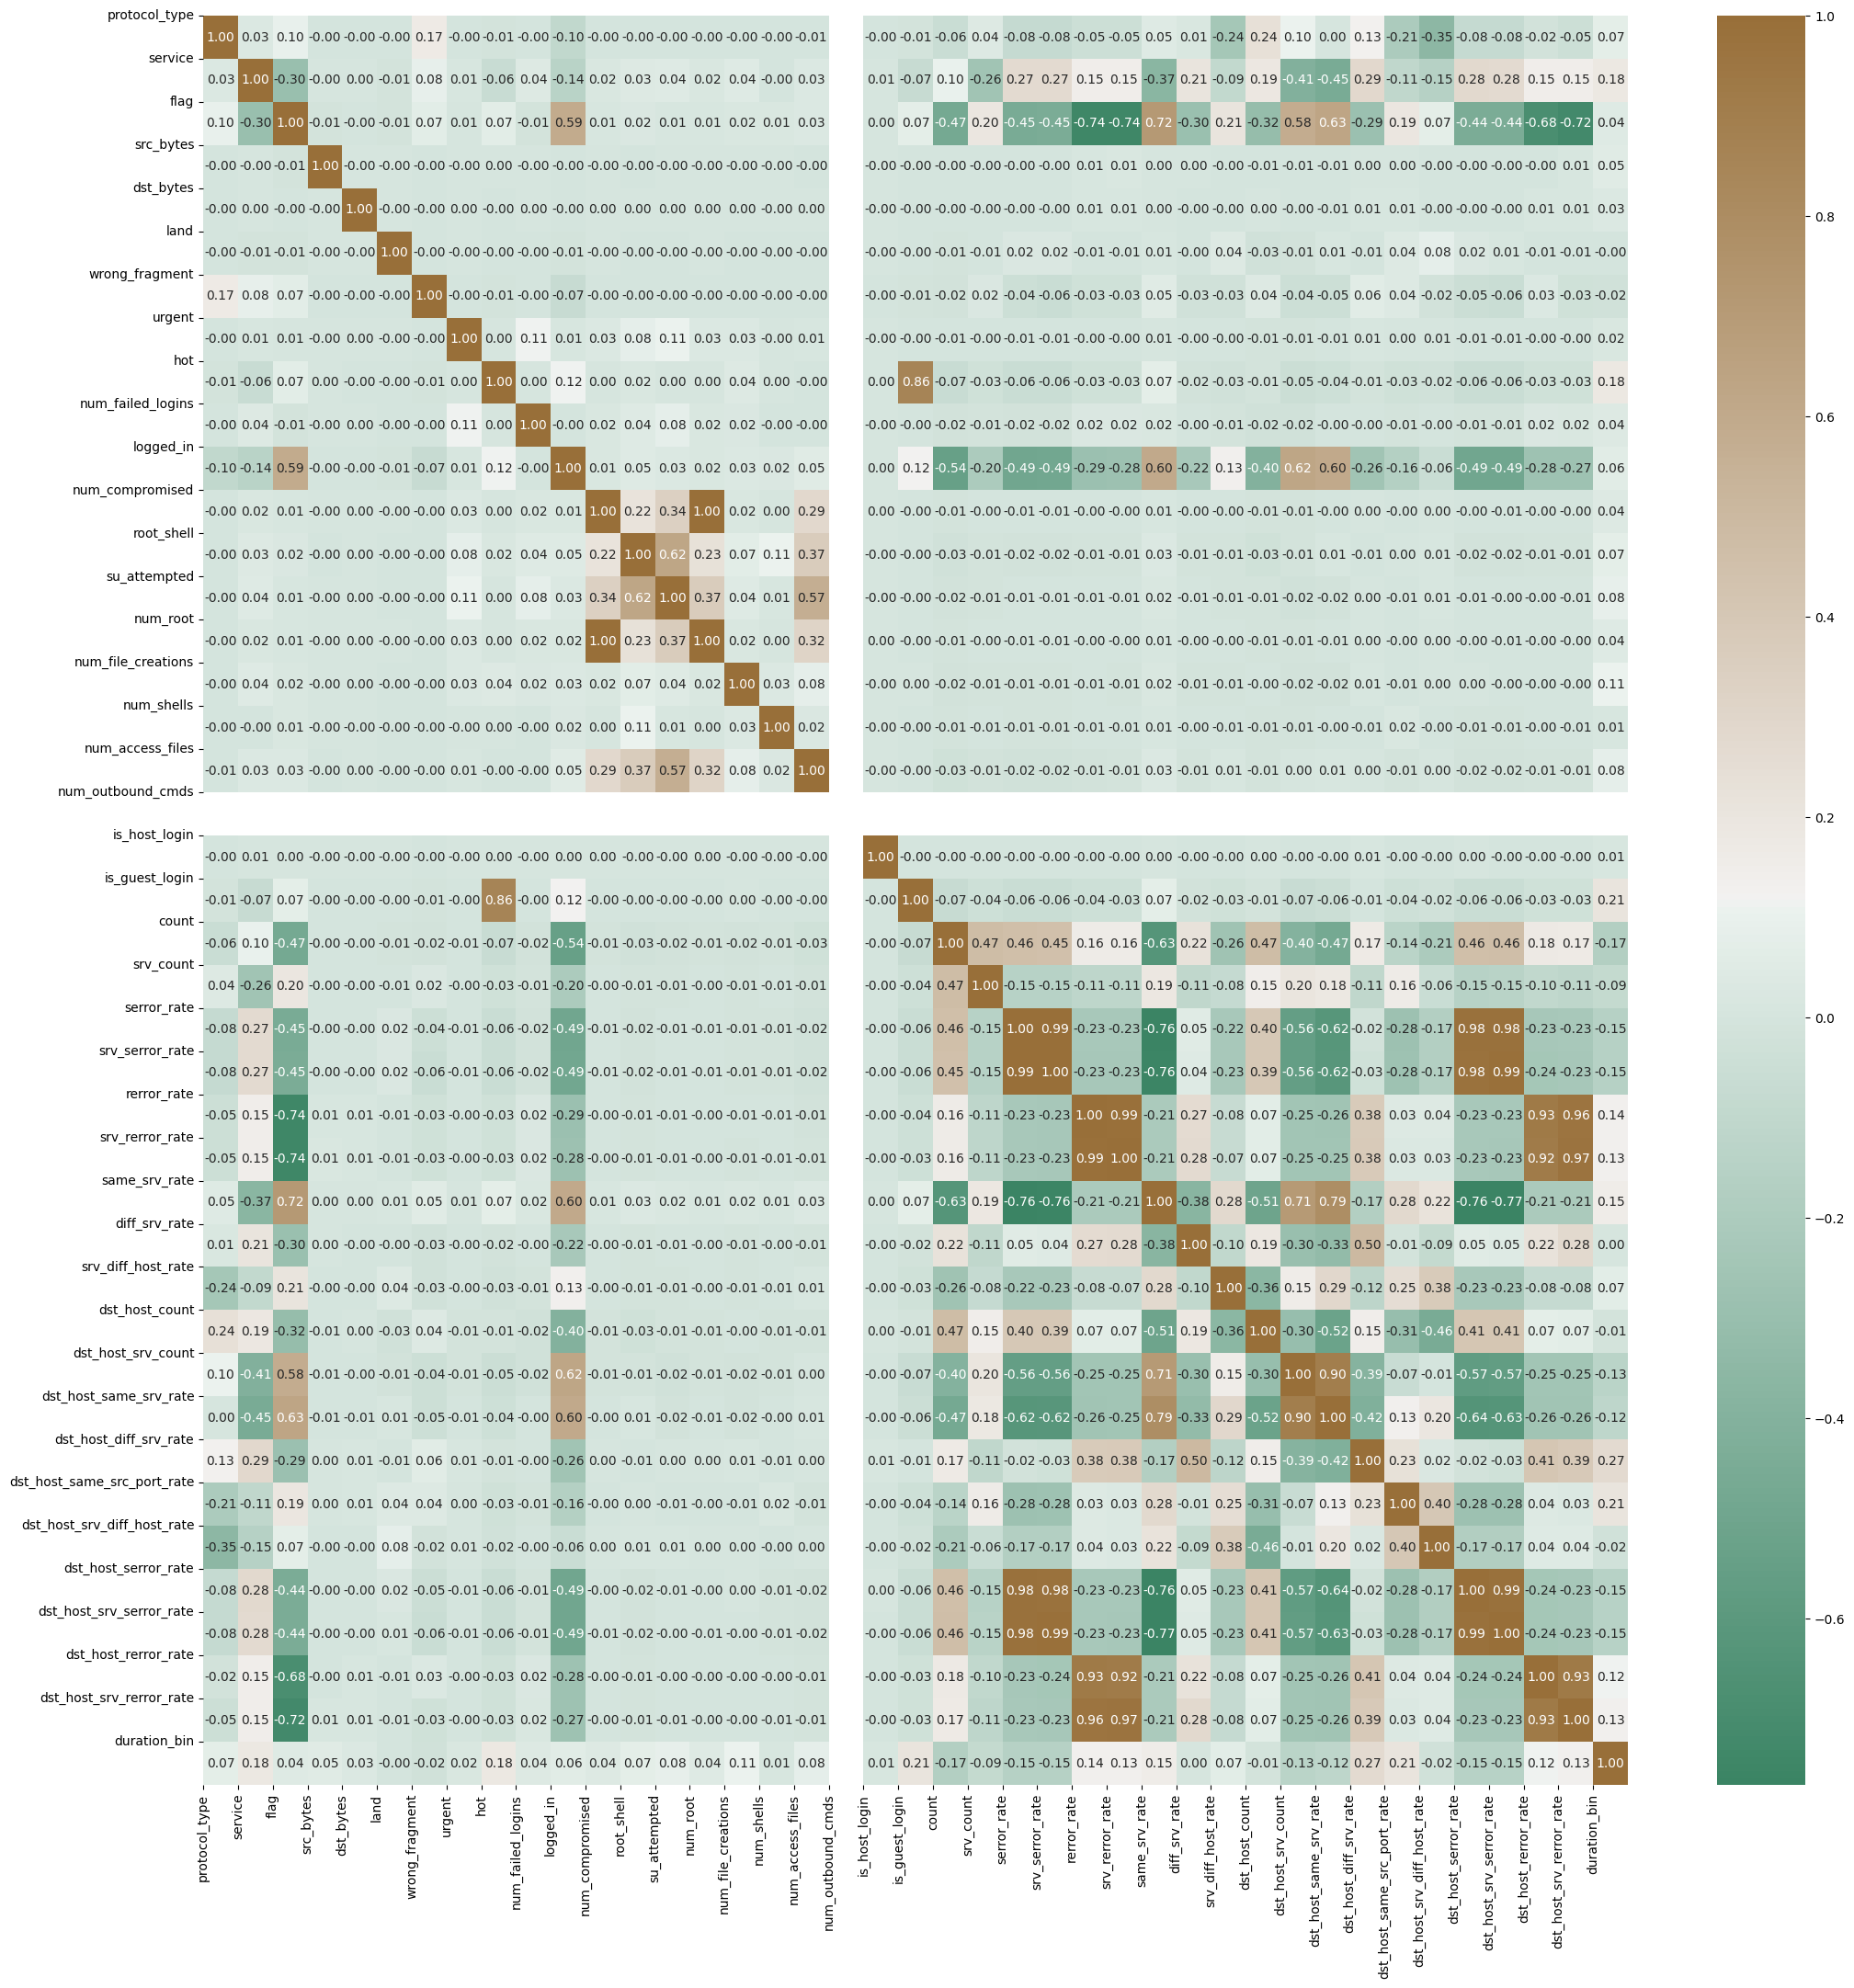

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = x_train.corr()
fig , ax = plt.subplots(figsize = (25,25))
colormap = sns.diverging_palette(150 , 50 , as_cmap = True)
sns.heatmap(corr , cmap = colormap , annot = True , fmt = ".2f")
plt.xticks(range(len(corr.columns)) , corr.columns)
plt.yticks(range(len(corr.columns)) , corr.columns)
plt.show()


CHECK ONE SIDE OF DIAGONAL, EITHER BELOW TRIANGLE OF DIAGONAL OR ELSE UPPER DIAGONAL

In [340]:
high_corr_cols = ['num_root' , 'srv_serror_rate' , 'srv_rerror_rate' , 'dst_host_serror_rate' , 'dst_host_srv_serror_rate']

In [341]:
# x_train = x_train.drop(columns=high_corr_cols)
# x_test = x_test.drop(columns=high_corr_cols)

In [342]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 50 , max_depth=10 , min_samples_split= 5  , random_state=42)

In [343]:
rf.fit(x_train , y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50,
                       random_state=42)

In [344]:
y_test_pred = rf.predict(x_test)

In [345]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9963


In [346]:
y_train_pred = rf.predict(x_train)

In [347]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train , y_train_pred)
print(f"Train Accuracy: {accuracy:.4f}")

Train Accuracy: 0.9975


In [348]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation Accuracy: 0.9966 ± 0.0005


In [349]:
from sklearn.linear_model import LogisticRegression

In [350]:
lr = LogisticRegression( random_state=42  , multi_class= 'multinomial' , max_iter=100)

In [351]:
lr.fit(x_train , y_train)

c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=42)

In [352]:
y_test_pred = lr.predict(x_test)

In [353]:
y_train_pred = lr.predict(x_train)

In [354]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(lr, x_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in

Cross-validation Accuracy: 0.8536 ± 0.0007


c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [355]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train , y_train_pred)
print(f"Train Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8497
Train Accuracy: 0.8517
